###  This document is Specifically for Overall Exam Time Analysis

### Instruction on how to use this document is given right before each section. 

#### The 3 sections are:
#### 1) Execution.
#### 2) Exporting Processed File.
#### 3) Plot and Visualization.

### Import Libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

### Read Data

In [38]:
def read_data(file_path):
    '''Read Excel File'''
    
    df = pd.read_excel(file_path, engine = 'openpyxl')

    return df

### Prep and Extract Speific Data for time analysis

In [39]:
def prep_total_time_data(df):
    '''Extract relevant data for total time analysis and create new df'''
   
    exam_time_df = df.groupby('candidate_id', as_index=False).first()[
    ['candidate_id', 'exam_start_time', 'exam_last_modified_time', 'extra_time_mins', 'incident_time_mins', 'total_score']
    ]

    return exam_time_df

### Remove Extra and Incident Time from Last modified time

In [40]:
def remove_extra_time(df):
    '''Remove extra and incident time from last_modified_time '''
    df['last_modified_time_without_extra_time'] = (
    df['exam_last_modified_time']
    - pd.to_timedelta(df['extra_time_mins'], unit='m')
    - pd.to_timedelta(df['incident_time_mins'], unit='m')
    )
    return df

### Calculate time usage with extra and incident time

In [41]:
def calc_time_usage_stats_with_extra(df, max_minutes = 210):
    """
    Calculate and adds time usage columns to the DataFrame (df):
      - Brukt_tid: total time used in minutes
      - Tid_igjen: remaining time in minutes
      - Prosent_brukt: percent of allowed time used
    """
    df = df.copy() 
    
    # Calculate how much time was used (in minutes), rounded to 2 decimal places

    df["Total_time_used_mins"] = round((df['exam_last_modified_time'] - df['exam_start_time']).dt.total_seconds() / 60 ,2)

    # Calculate how much time was left (maximum allowed minus used), rounded to 2 decimals 
    df["Remaining_time_mins"] = round(max_minutes - df["Total_time_used_mins"], 2)

    # Calculate percentage of allowed time used, rounded to 2 decimals
    df["%Time_used"] = round((df["Total_time_used_mins"] / max_minutes) * 100, 2)

    
    return df

### Calculate time usage without extra and incident time

In [42]:
def calc_time_usage_stats_without_extra(df, max_minutes = 210):
    """
    Calculate and adds time usage columns to the DataFrame (df):
      - Brukt_tid: total time used in minutes
      - Tid_igjen: remaining time in minutes
      - Prosent_brukt: percent of allowed time used
    """
    df = df.copy() 

    # remove extra time which added automatically to last modified time
    df = remove_extra_time(df)
    # Calculate how much time was used (in minutes), rounded to 2 decimal places
     
    df["Total_time_used_mins_without_extra"] = round((df['last_modified_time_without_extra_time'] - df['exam_start_time']).dt.total_seconds() / 60 ,2)

    # Calculate how much time was left (maximum allowed minus used), rounded to 2 decimals 
    df["Remaining_time_mins_without_extra"] = round(max_minutes - df["Total_time_used_mins_without_extra"], 2)

    # Calculate percentage of allowed time used, rounded to 2 decimals
    df["%Time_used_without_extra"] = round((df["Total_time_used_mins_without_extra"] / max_minutes) * 100, 2)

    
    return df

### Calculate statistic for boxplotting with extra and incident time

In [43]:
def calculate_stats_with_extra_time(df):
    ''' calulate statsitc value for boxplot'''
    q1 = df['Total_time_used_mins'].quantile(0.25)
    q2 = df['Total_time_used_mins'].quantile(0.5)  # median
    q3 = df['Total_time_used_mins'].quantile(0.75)
    iqr = q3 - q1
    
    # remove outliers from plotbox and stats
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Detect and remove outliers
    clean_df = detected_and_remove_outliers(df, lower_bound, upper_bound)

    #calc mean and median
    mean = df['Total_time_used_mins'].mean()
    median = df['Total_time_used_mins'].median()
    

    return q1, q2, q3, mean, iqr, clean_df


### Calculate statistic for boxplotting without extra and incident time

In [44]:
def calculate_stats_without_extra_time(df):
    ''' calulate statsitc value and remove outliers'''
    
    q1 = df['Total_time_used_mins_without_extra'].quantile(0.25)
    q2 = df['Total_time_used_mins_without_extra'].quantile(0.5)  # median
    q3 = df['Total_time_used_mins_without_extra'].quantile(0.75)
    iqr = q3 - q1
    
    # remove outliers from plotbox and stats
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Detect and remove outliers
    clean_df = detected_and_remove_outliers(df, lower_bound, upper_bound)

    #calc mean and median
    mean = df['Total_time_used_mins_without_extra'].mean()
    median = df['Total_time_used_mins_without_extra'].median()    

    return q1, q2, q3, mean, iqr, clean_df

    

### Detect and Remove outliers 

In [45]:
def detected_and_remove_outliers(df, lower_bound, upper_bound):

    # detect outliter
    outliers = df[
    (df['Total_time_used_mins_without_extra'] < lower_bound) |
    (df['Total_time_used_mins_without_extra'] > upper_bound)
    ]

    # remove outlier
    clean_df = df[
    (df['Total_time_used_mins_without_extra'] >= lower_bound) &
    (df['Total_time_used_mins_without_extra'] <= upper_bound)
    ]

    print(f"Outliers removed:\n{outliers[['candidate_id', 'Total_time_used_mins_without_extra']]}")


    return clean_df
    

### Boxplot: avg of overall time used (with extra and incident time)

In [46]:
def plot_overall_avg_exam_time_with_extra(df):
    ''' overview of avg overall time taken with extra/incident time'''

    q1, q2, q3, mean, iqr, df_stats = calculate_stats_with_extra_time(df)

    plt.figure(figsize=(8,6)) 
    sns.boxplot(y=df_stats['Total_time_used_mins'], color='lightblue', width=0.3)
    plt.ylabel('Total Time Used (mins)')
    plt.title('Distribution of Total Exam Time Used With Extra Time')
    plt.grid(True)
    plt.tight_layout()


    # Adjust x-axis limits to center boxplot
    plt.xlim(-0.5, 0.5)

    # Horizontal lines for median and mean
    plt.hlines(y=q2, xmin=-0.15, xmax=0.15, color='green', linestyle='--', linewidth=1)
    plt.hlines(y=mean, xmin=-0.15, xmax=0.15, color='red', linestyle='-.', linewidth=1.5)

    # Create legend handles for lines with labels and values
    median_handle = mlines.Line2D([], [], color='green', linestyle='--', linewidth=1, label=f"Median (Q2): {q2:.2f}")
    mean_handle = mlines.Line2D([], [], color='red', linestyle='-.', linewidth=1.5, label=f"Mean: {mean:.2f}")

    # Add text-only entry for Q1, Q3, IQR
    stats_text = f"Q1: {q1:.2f} \n Q3: {q3:.2f}  \n IQR: {iqr:.2f}"
    stats_patch = mpatches.Patch(color='none', label=stats_text)

    plt.legend(handles=[median_handle, mean_handle, stats_patch], loc='upper right', fontsize=10, frameon=True)
    plt.show()

### Boxplot: avg of overall time used (Without extra and incident time)

In [47]:
def plot_overall_avg_exam_time_without_extra(df):
    ''' overview of avg overall time taken without extra/incident time'''

    q1, q2, q3, mean, iqr, df_stats = calculate_stats_without_extra_time(df)

    plt.figure(figsize=(8,6)) 
    sns.boxplot(y=df_stats['Total_time_used_mins_without_extra'], color='lightblue', width=0.3)
    plt.ylabel('Total Time Used (mins)')
    plt.title('Distribution of Total Exam Time Used Without Extra Time')
    plt.grid(True)
    plt.tight_layout()


    # Adjust x-axis limits to center boxplot
    plt.xlim(-0.5, 0.5)

    # Horizontal lines for median and mean
    plt.hlines(y=q2, xmin=-0.15, xmax=0.15, color='green', linestyle='--', linewidth=1)
    plt.hlines(y=mean, xmin=-0.15, xmax=0.15, color='red', linestyle='-.', linewidth=1.5)

    # Create legend handles for lines with labels and values
    median_handle = mlines.Line2D([], [], color='green', linestyle='--', linewidth=1, label=f"Median (Q2): {q2:.2f}")
    mean_handle = mlines.Line2D([], [], color='red', linestyle='-.', linewidth=1.5, label=f"Mean: {mean:.2f}")

    # Add text-only entry for Q1, Q3, IQR
    stats_text = f"Q1: {q1:.2f} \n Q3: {q3:.2f}  \n IQR: {iqr:.2f}"
    stats_patch = mpatches.Patch(color='none', label=stats_text)

    plt.legend(handles=[median_handle, mean_handle, stats_patch], loc='upper right', fontsize=10, frameon=True)
    plt.show()

### Boxplot: overall time used and associated grade category (With extra/incident time)

In [49]:
def plot_time_and_grades_with_extra_time(df):
    max_score = df['total_score'].max()
    # Define grade thresholds as % of max score
    score_mapping = { 
        'A' : 0.92 * max_score,
        'B' : 0.77 * max_score,
        'C' : 0.58 * max_score, 
        'D' : 0.46 * max_score,
        'E' : 0.40 * max_score, 
        'F' : 0.00 * max_score   
    }

    # Sort bins
    sorted_grades = sorted(score_mapping.items(), key=lambda x: x[1])
    labels = [grade for grade, _ in sorted_grades]
    bins = [score for _, score in sorted_grades]

    # Ensure bins increase strictly — avoid duplicate max
    if max_score <= bins[-1]:
        bins[-1] += 0.0001  # bump up the last bin slightly
    else:
        bins.append(max_score + 0.0001)

    # Grade classification
    df['grade_category'] = pd.cut(
        df['total_score'], 
        bins=bins, 
        labels=labels,
        include_lowest=True
    )

    # Set order
    category_order = ['F', 'E', 'D', 'C', 'B', 'A']
    df['grade_category'] = pd.Categorical(
        df['grade_category'],
        categories=category_order,
        ordered=True
    )

    # Count per grade
    counts = df['grade_category'].value_counts().reindex(category_order)

    # Labels for x-axis
    labels_with_counts = [
        f"{cat}\n(n={counts[cat] if not pd.isna(counts[cat]) else 0})"
        for cat in category_order
    ]

    # Plot
    plt.figure(figsize=(12,8))

    sns.boxplot(
        x='grade_category',
        y='Total_time_used_mins',
        hue='grade_category',
        data=df,
        palette='Blues',
        legend=False
    )

    sns.pointplot(
        x='grade_category',
        y='Total_time_used_mins',
        data=df,
        color='red',
        estimator='mean',
        errorbar=None,
        linestyles='',
        markers='D',
        label="mean"
    )

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlabel('Grade Category')
    plt.ylabel('Total Time Used (mins)')
    plt.title('Time Used by Grade Category (With Extra Time)')
    plt.xticks(ticks=range(len(category_order)), labels=labels_with_counts)
    plt.tight_layout()
    plt.legend()
    plt.show()

    # Optional: return modified DataFrame
    # return df


### Boxplot: overall time used and associated grade category (Without extra/incident time)

In [50]:
def plot_time_and_grades_without_extra_time(df):
    max_score = df['total_score'].max()

    # Define grade thresholds as % of max score
    score_mapping = { 
        'A' : 0.92 * max_score,
        'B' : 0.77 * max_score,
        'C' : 0.58 * max_score, 
        'D' : 0.46 * max_score,
        'E' : 0.40 * max_score, 
        'F' : 0.00 * max_score   
    }

    # Sort bins
    sorted_grades = sorted(score_mapping.items(), key=lambda x: x[1])
    labels = [grade for grade, _ in sorted_grades]
    bins = [score for _, score in sorted_grades]

    # Ensure bins increase strictly — avoid duplicate max
    if max_score <= bins[-1]:
        bins[-1] += 0.0001  # bump up the last bin slightly
    else:
        bins.append(max_score + 0.0001)

    # Grade classification
    df['grade_category'] = pd.cut(
        df['total_score'], 
        bins=bins, 
        labels=labels,
        include_lowest=True
    )

    # Set order
    category_order = ['F', 'E', 'D', 'C', 'B', 'A']
    df['grade_category'] = pd.Categorical(
        df['grade_category'],
        categories=category_order,
        ordered=True
    )

    # Count per grade
    counts = df['grade_category'].value_counts().reindex(category_order)

    # Labels for x-axis
    labels_with_counts = [
        f"{cat}\n(n={counts[cat] if not pd.isna(counts[cat]) else 0})"
        for cat in category_order
    ]

    # Plot
    plt.figure(figsize=(12,8))

    sns.boxplot(
        x='grade_category',
        y='Total_time_used_mins_without_extra',
        hue='grade_category',
        data=df,
        palette='Blues',
        legend=False
    )

    sns.pointplot(
        x='grade_category',
        y='Total_time_used_mins_without_extra',
        data=df,
        color='red',
        estimator='mean',
        errorbar=None,
        linestyles='',
        markers='D',
        label="mean"
    )

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlabel('Grade Category')
    plt.ylabel('Total Time Used (mins)')
    plt.title('Time Used by Grade Category (With Extra Time)')
    plt.xticks(ticks=range(len(category_order)), labels=labels_with_counts)
    plt.tight_layout()
    plt.legend()
    plt.show()

    # Optional: return modified DataFrame
    # return df

    

### ##################---------------Main Execution Functions Here-------------------##################

### Main function to run all pervious functins

In [51]:
def run_analysis(file_path):
    ''' Run and process data analysis'''

    # Read Data
    df = read_data(file_path)

    # prep and extract data from original df for time per task analysis
    exam_time_df = prep_total_time_data(df)

    # convert time taken per task from second to minutes
    exam_time_df = calc_time_usage_stats_with_extra(exam_time_df, max_minutes = 210)

    exam_time_df = calc_time_usage_stats_without_extra(exam_time_df, max_minutes = 210)


    # calculate ideal time 
   # exam_time_df = calculate_ideal_time_per_task(exam_time_df)

    return exam_time_df


### Expore Data into a file

In [52]:
def export_data(df, output_path, file_format='xlsx'):
    """
    Save cleaned data to file
    Args:
        df (pandas.DataFrame): Cleaned DataFrame
        output_path (str): Path to save the file
        file_format (str): Format to save ('xlsx', 'csv', 'json')
    """
    try:
        if file_format == 'xlsx':
            df.to_excel(output_path, index=False)
        elif file_format == 'csv':
            df.to_csv(output_path, index=False)
        elif file_format == 'json':
            df.to_json(output_path, orient='records', indent=2)
        else:
            raise ValueError(f"Unsupported format: {file_format}")
        
        print(f"Data saved successfully to {output_path}")
    except Exception as e:
        print(f"Error saving data: {e}")

### ####################---------------Execute Analysis Here -------------------#########################

## 1) Execute Analysis

In [53]:
# Read our data file
exam_time_df = run_analysis("data/cleaned_data_with_manual_scores2024.xlsx")
exam_time_df

,candidate_id,exam_start_time,exam_last_modified_time,extra_time_mins,incident_time_mins,total_score,Total_time_used_mins,Remaining_time_mins,%Time_used,last_modified_time_without_extra_time,Total_time_used_mins_without_extra,Remaining_time_mins_without_extra,%Time_used_without_extra
0,17104,2024-12-11 14:00:02,2024-12-11 17:55:47,0,0,89.74,235.75,-25.75,112.26,2024-12-11 17:55:47,235.75,-25.75,112.26
1,17105,2024-12-11 14:00:01,2024-12-11 17:48:51,0,0,70.88,228.83,-18.83,108.97,2024-12-11 17:48:51,228.83,-18.83,108.97
2,17106,2024-12-11 14:00:02,2024-12-11 17:46:31,0,0,37.64,226.48,-16.48,107.85,2024-12-11 17:46:31,226.48,-16.48,107.85
3,17107,2024-12-11 14:00:02,2024-12-11 15:57:52,0,0,76.81,117.83,92.17,56.11,2024-12-11 15:57:52,117.83,92.17,56.11
4,17111,2024-12-11 14:00:04,2024-12-11 18:14:54,30,0,35.71,254.83,-44.83,121.35,2024-12-11 17:44:54,224.83,-14.83,107.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,17840,2024-12-11 14:00:07,2024-12-11 17:51:44,0,0,75.33,231.62,-21.62,110.30,2024-12-11 17:51:44,231.62,-21.62,110.30
565,17841,2024-12-11 14:00:07,2024-12-11 18:26:29,30,0,63.18,266.37,-56.37,126.84,2024-12-11 17:56:29,236.37,-26.37,112.56
566,17842,2024-12-11 14:00:01,2024-12-11 17:07:56,0,0,62.31,187.92,22.08,89.49,2024-12-11 17:07:56,187.92,22.08,89.49
567,17843,2024-12-11 14:00:01,2024-12-11 16:51:06,0,0,60.50,171.08,38.92,81.47,2024-12-11 16:51:06,171.08,38.92,81.47


### ####################---------------Export Processed File Here -------------------######################

## 2) Export Proccessed Analysis File

In [54]:
# export_data(exam_time_df, 'processed data/Total_Exam_Time_Analysis_2024.xlsx', 'xlsx')

### ####################---------------Visualize and Plot Here-------------------######################

## 3) Visualization of Data

#### There are 4 visualization functions in here:

##### 1) plot_overall_avg_exam_time_extra(exam_time_df)
##### 2) plot_overall_avg_exam_time_without_extra(exam_time_df)
##### 3) plot_time_and_grades_with_extra_time(exam_time_df)
##### 4) plot_time_and_grades_without_extra_time(exam_time_df)

#### How to use: to plot just pass the dataframe (exam_time_df), wehich you get from the run_analysis method.

Outliers removed:
     candidate_id  Total_time_used_mins_without_extra
98          17244                               57.28
273         17465                               49.25
411         17639                               40.75


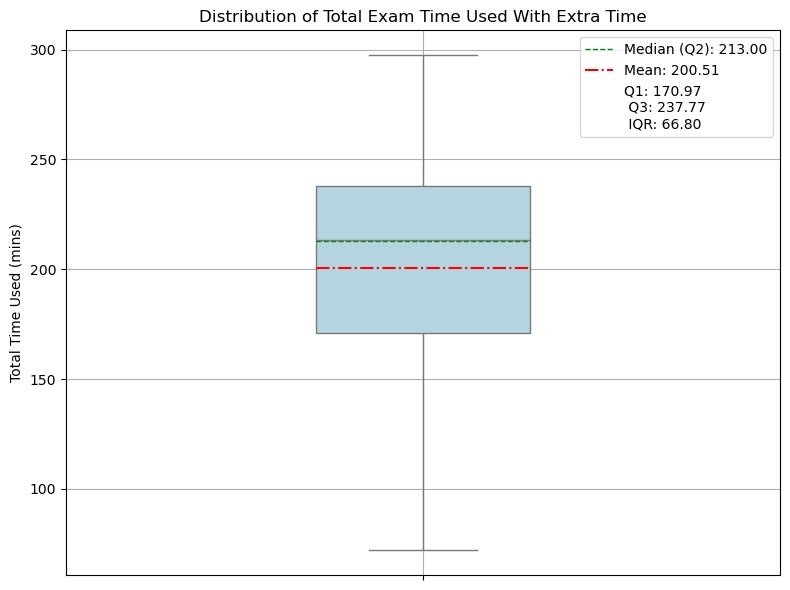

In [55]:
# Boxplot of avg time used (including extra/incident time).
plot_overall_avg_exam_time_with_extra(exam_time_df)

Outliers removed:
     candidate_id  Total_time_used_mins_without_extra
98          17244                               57.28
273         17465                               49.25
411         17639                               40.75


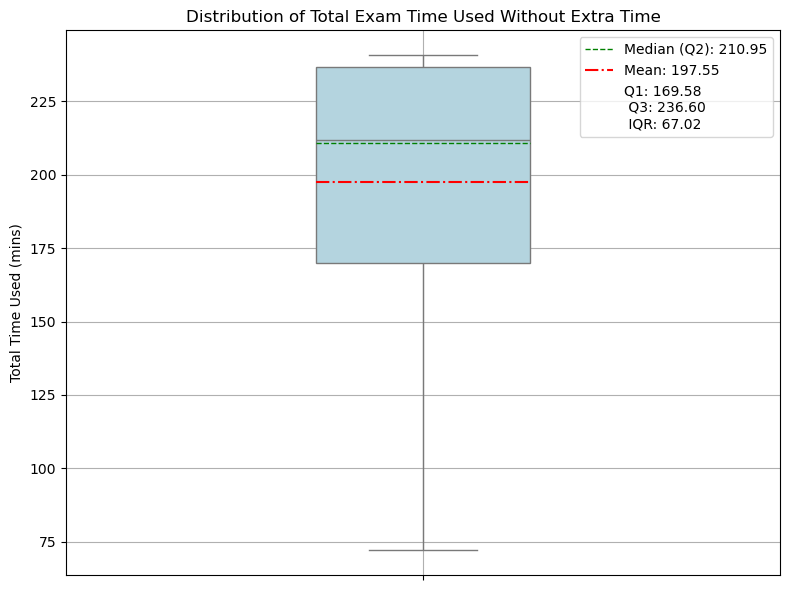

In [56]:
# Boxplot of avg time used (exluding extra/incident time).
plot_overall_avg_exam_time_without_extra(exam_time_df)

### Boxplot total time per grade category (Including Extra/Incided Time)

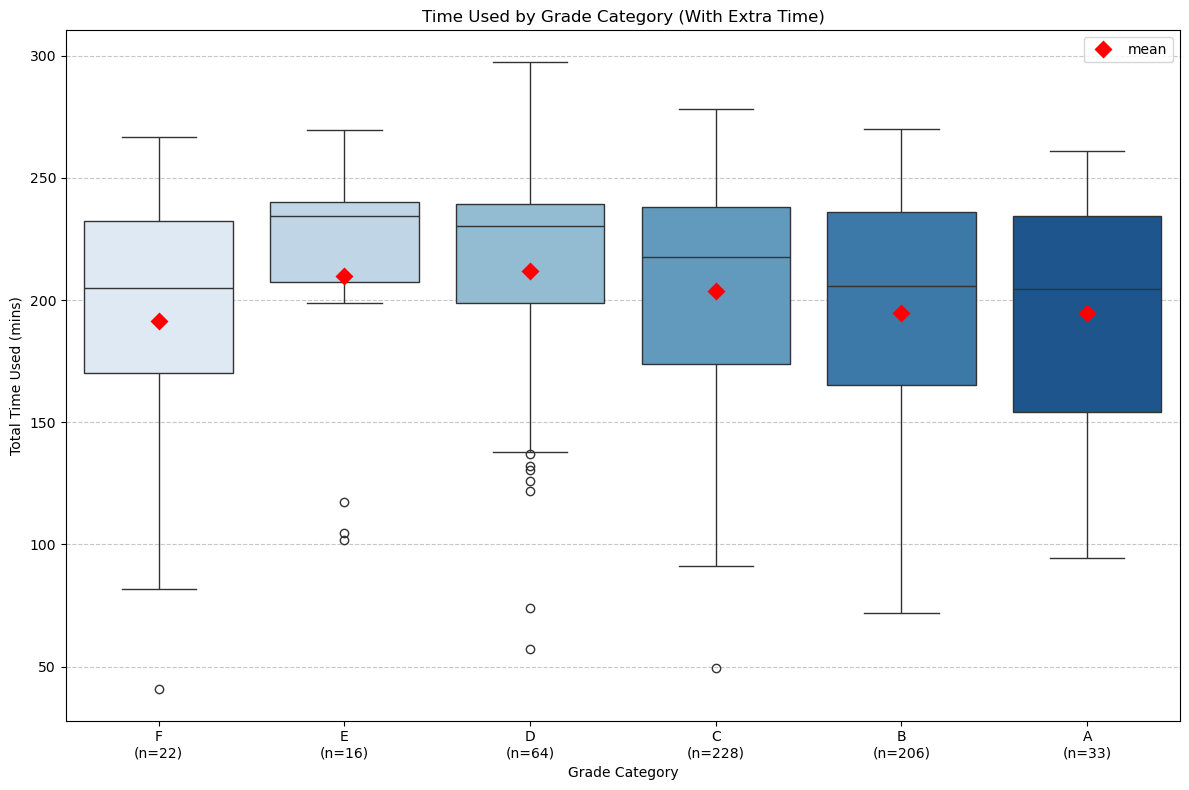

In [57]:
plot_time_and_grades_with_extra_time1(exam_time_df)

### Boxplot total time per grade category (Excluding Extra/Incided Time)

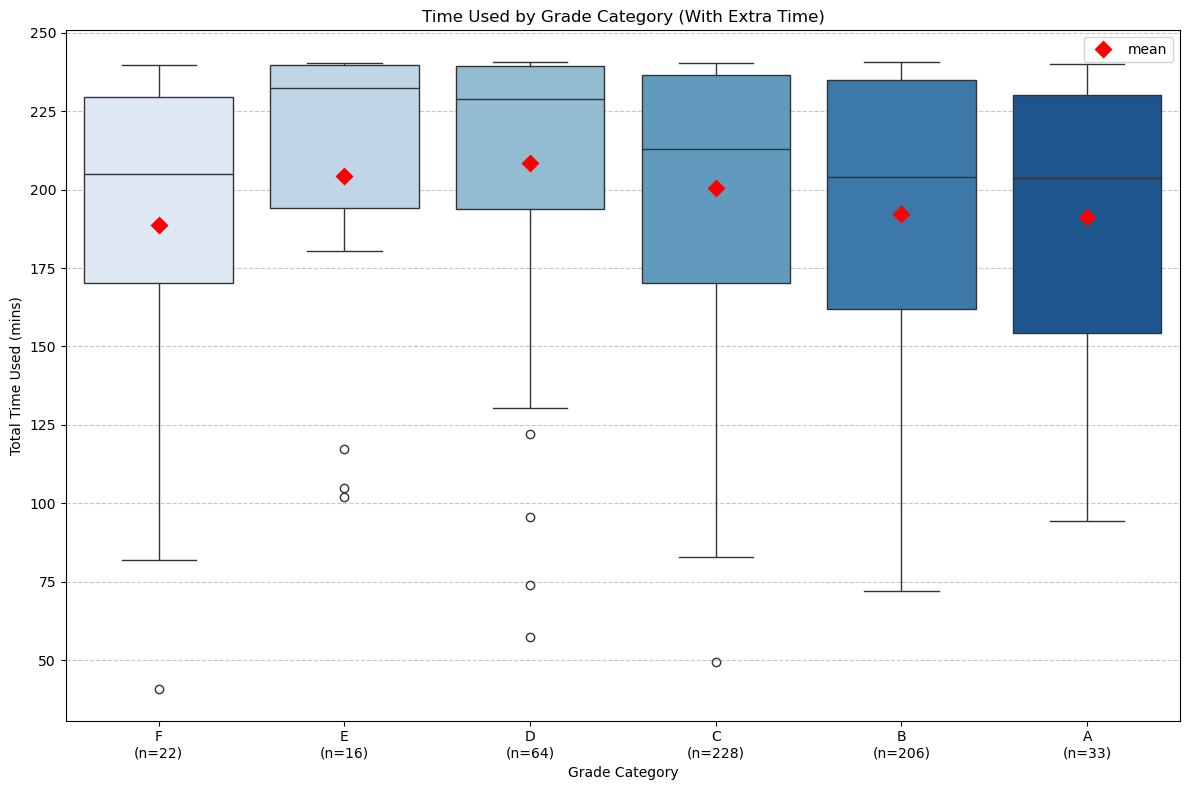

In [58]:
plot_time_and_grades_without_extra_time(exam_time_df)